In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, precision_score, confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("loan_data.csv")

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

In [4]:
data.columns

Index(['credit.policy', 'purpose', 'int.rate', 'installment', 'log.annual.inc',
       'dti', 'fico', 'days.with.cr.line', 'revol.bal', 'revol.util',
       'inq.last.6mths', 'delinq.2yrs', 'pub.rec', 'not.fully.paid'],
      dtype='object')

In [5]:
# check for duplicates - no duplicates 
print(data.duplicated().sum())

0


In [6]:
# check for missing values - no missing values
data.isnull().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

### Data Analysis

#### 1 - Credit Policy

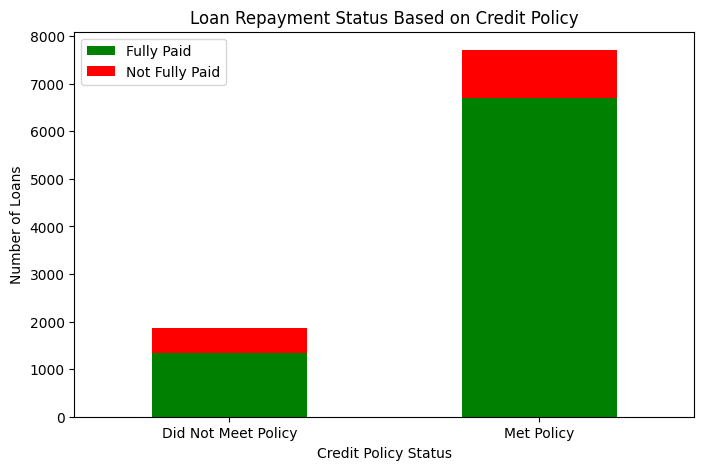

In [7]:
# Count of fully paid and not fully paid for both groups
credit_policy_counts = data.groupby(["credit.policy", "not.fully.paid"]).size().unstack()

# Rename index for better readability
credit_policy_counts.index = ["Did Not Meet Policy", "Met Policy"]

# Stacked Bar Chart
credit_policy_counts.plot(kind="bar", stacked=True, color=["green", "red"], figsize=(8, 5))
plt.xlabel("Credit Policy Status")
plt.ylabel("Number of Loans")
plt.title("Loan Repayment Status Based on Credit Policy")
plt.legend(["Fully Paid", "Not Fully Paid"])
plt.xticks(rotation=0)
plt.show()



#### 2 - Purpose

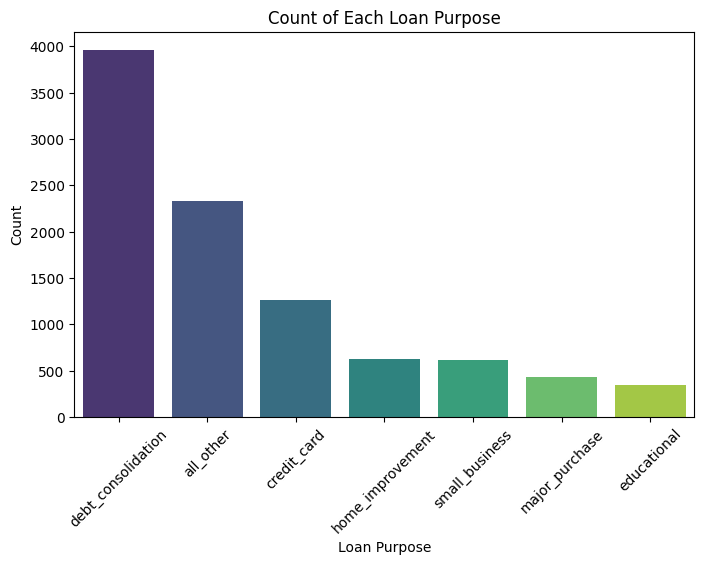

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each loan purpose
purpose_counts = data["purpose"].value_counts()

# Bar plot of loan purpose distribution
plt.figure(figsize=(8, 5))
sns.barplot(
    x=purpose_counts.index,
    y=purpose_counts.values,
    hue=purpose_counts.index,  # Assign `hue` to x variable
    palette="viridis",
    legend=False  # Disable legend since hue is just for color
)

# Labels and title
plt.xlabel("Loan Purpose")
plt.ylabel("Count")
plt.title("Count of Each Loan Purpose")
plt.xticks(rotation=45)  # Rotate labels for readability

plt.show()

<Figure size 1000x600 with 0 Axes>

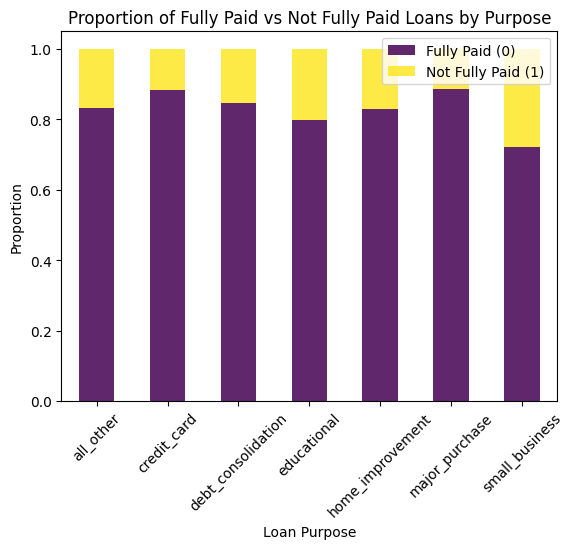

In [9]:
# Calculate proportion of fully paid vs not fully paid for each loan purpose
purpose_payment_counts = data.groupby("purpose")["not.fully.paid"].value_counts(normalize=True).unstack()

# Bar plot to show proportions
plt.figure(figsize=(10, 6))
purpose_payment_counts.plot(kind="bar", stacked=True, colormap="viridis", alpha=0.85)

# Labels and title
plt.xlabel("Loan Purpose")
plt.ylabel("Proportion")
plt.title("Proportion of Fully Paid vs Not Fully Paid Loans by Purpose")
plt.xticks(rotation=45)
plt.legend(["Fully Paid (0)", "Not Fully Paid (1)"], loc="upper right")

plt.show()


#### 2 - Purpose - One hot encoding of purpose

In [10]:
# One-hot encoding the 'purpose' column
data = pd.get_dummies(data, columns=["purpose"], prefix="purpose", dtype=int)

In [11]:
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0,0,0,1,0,0,0,0
1,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0,0,1,0,0,0,0,0
2,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0,0,0,1,0,0,0,0
3,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0,0,0,1,0,0,0,0
4,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0,0,1,0,0,0,0,0


#### 3 - int.rate

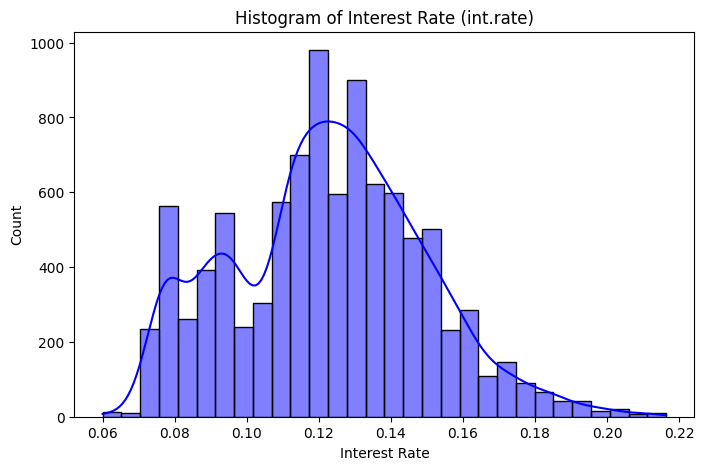

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of interest rate (int.rate)
plt.figure(figsize=(8, 5))
sns.histplot(data["int.rate"], bins=30, kde=True, color="blue")

# Labels and title
plt.xlabel("Interest Rate")
plt.ylabel("Count")
plt.title("Histogram of Interest Rate (int.rate)")

plt.show()


In [13]:
# Calculate correlation between FICO score and Interest Rate - Expecting negative
fico_int_rate_corr = data["fico"].corr(data["int.rate"])

# Display the correlation
fico_int_rate_corr

-0.7148207714193595

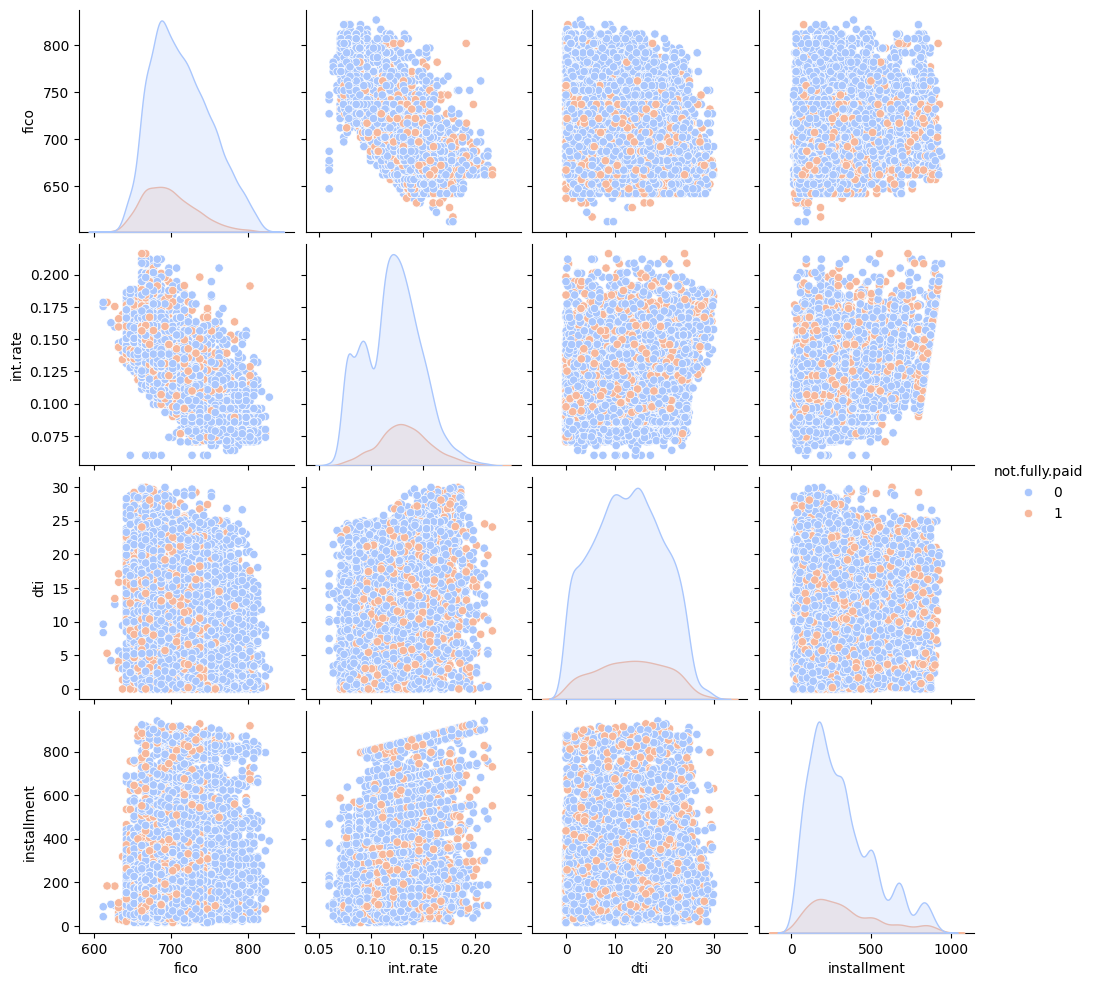

In [14]:
# Selecting relevant columns for the pairplot
columns_to_plot = ["fico", "int.rate", "dti", "installment", "not.fully.paid"]

# Creating the pairplot
sns.pairplot(data[columns_to_plot], hue="not.fully.paid", diag_kind="kde", palette="coolwarm")

# Show the plot
plt.show()


In [15]:
# now I should be data transforming and everything with the intrest rate 

In [16]:
data["int.rate"].describe()

count    9578.000000
mean        0.122640
std         0.026847
min         0.060000
25%         0.103900
50%         0.122100
75%         0.140700
max         0.216400
Name: int.rate, dtype: float64

In [17]:
# Initialize MinMaxScaler (Neural networks perform best with normalized inputs)
scaler = MinMaxScaler()

# Fit and transform 'int.rate' to scale values between 0 and 1
# MinMaxScaler is used because it keeps the data in a fixed range, which helps in stable training of Dense layers
data["int.rate"] = scaler.fit_transform(data[["int.rate"]])

# Display transformed statistics to verify scaling
print(data["int.rate"].describe()) 

count    9578.000000
mean        0.400512
std         0.171656
min         0.000000
25%         0.280691
50%         0.397059
75%         0.515985
max         1.000000
Name: int.rate, dtype: float64


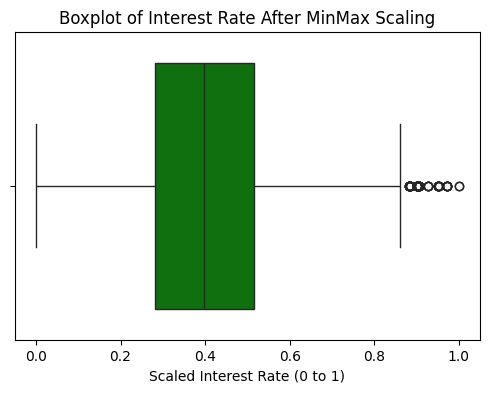

In [18]:
plt.figure(figsize=(6, 4))

# Boxplot to check for outliers
sns.boxplot(x=data["int.rate"], color="green")

plt.xlabel("Scaled Interest Rate (0 to 1)")
plt.title("Boxplot of Interest Rate After MinMax Scaling")

plt.show()

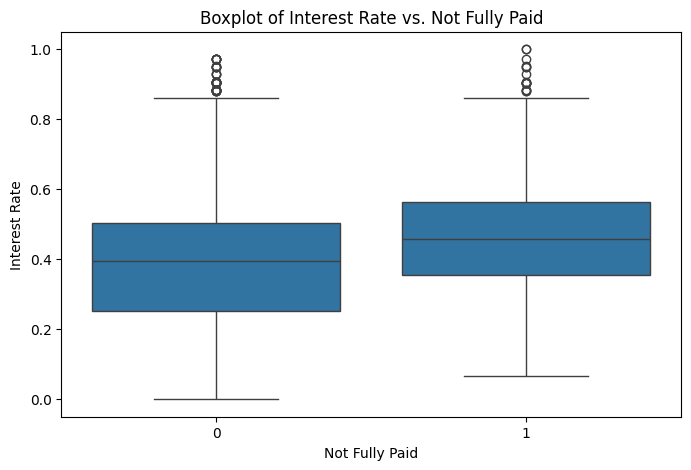

In [19]:
# Generate boxplot for int.rate vs. not.fully.paid
plt.figure(figsize=(8, 5))
sns.boxplot(x=data['not.fully.paid'], y=data['int.rate'])
plt.xlabel("Not Fully Paid")
plt.ylabel("Interest Rate")
plt.title("Boxplot of Interest Rate vs. Not Fully Paid")
plt.show()

#### 4 - installment

In [20]:
data["installment"].describe()

count    9578.000000
mean      319.089413
std       207.071301
min        15.670000
25%       163.770000
50%       268.950000
75%       432.762500
max       940.140000
Name: installment, dtype: float64

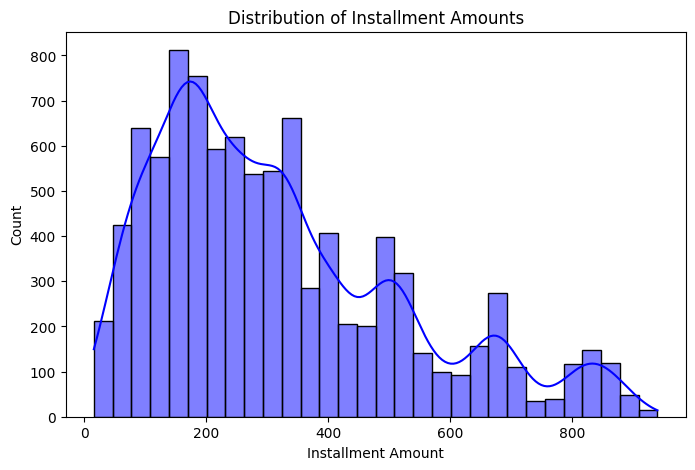

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(data["installment"], bins=30, kde=True, color="blue")

plt.xlabel("Installment Amount")
plt.ylabel("Count")
plt.title("Distribution of Installment Amounts")
plt.show()

In [22]:
#scaling

In [23]:
scaler = MinMaxScaler()
data["installment"] = scaler.fit_transform(data[["installment"]])

#### 5 - log.annual.inc

In [24]:
data["log.annual.inc"].describe()

count    9578.000000
mean       10.932117
std         0.614813
min         7.547502
25%        10.558414
50%        10.928884
75%        11.291293
max        14.528354
Name: log.annual.inc, dtype: float64

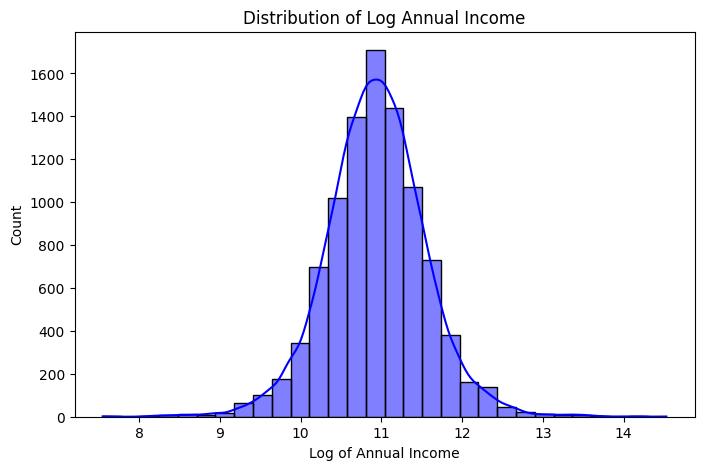

In [25]:
# Histogram of log.annual.inc
plt.figure(figsize=(8, 5))
sns.histplot(data["log.annual.inc"], bins=30, kde=True, color="blue")

# Labels and title
plt.xlabel("Log of Annual Income")
plt.ylabel("Count")
plt.title("Distribution of Log Annual Income")

plt.show()

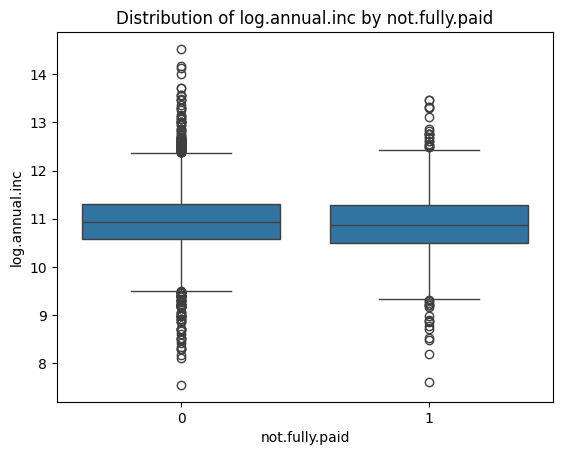

In [26]:
sns.boxplot(x='not.fully.paid', y='log.annual.inc', data=data)
plt.title("Distribution of log.annual.inc by not.fully.paid")
plt.show()

#### 6 - dti

In [27]:
data["dti"].describe()

count    9578.000000
mean       12.606679
std         6.883970
min         0.000000
25%         7.212500
50%        12.665000
75%        17.950000
max        29.960000
Name: dti, dtype: float64

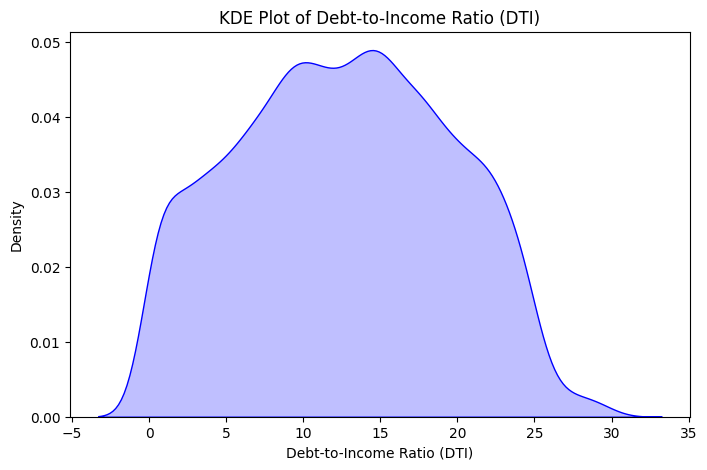

In [28]:
# KDE plot for Debt-to-Income Ratio (DTI)
plt.figure(figsize=(8, 5))
sns.kdeplot(data["dti"], fill=True, color="blue")  # Replaced shade=True with fill=True

# Labels and title
plt.xlabel("Debt-to-Income Ratio (DTI)")
plt.ylabel("Density")
plt.title("KDE Plot of Debt-to-Income Ratio (DTI)")

plt.show()

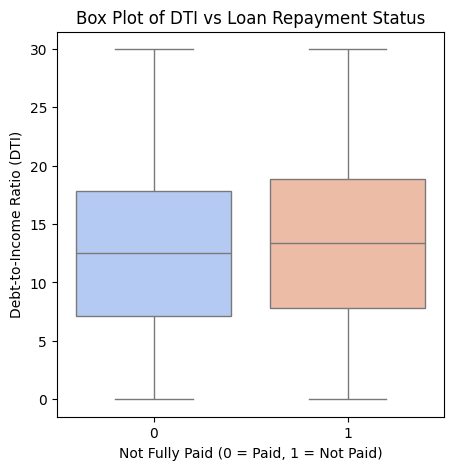

In [29]:
# Box plot of DTI vs Not Fully Paid
plt.figure(figsize=(5, 5))
sns.boxplot(
    x=data["not.fully.paid"],
    y=data["dti"],
    hue=data["not.fully.paid"],  # Assign hue to x variable
    palette="coolwarm",
    legend=False  # Disable legend since hue is just for color
)

# Labels and title
plt.xlabel("Not Fully Paid (0 = Paid, 1 = Not Paid)")
plt.ylabel("Debt-to-Income Ratio (DTI)")
plt.title("Box Plot of DTI vs Loan Repayment Status")

plt.show()

In [30]:
scaler = MinMaxScaler()
data["dti"] = scaler.fit_transform(data[["dti"]])

#### 7 - fico

In [31]:
data['fico'].describe()

count    9578.000000
mean      710.846314
std        37.970537
min       612.000000
25%       682.000000
50%       707.000000
75%       737.000000
max       827.000000
Name: fico, dtype: float64

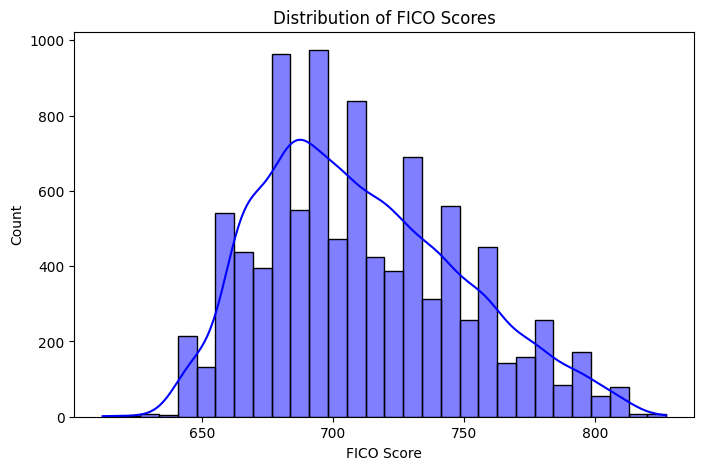

In [32]:
# Histogram of FICO Score
plt.figure(figsize=(8, 5))
sns.histplot(data["fico"], bins=30, kde=True, color="blue")

# Labels and title
plt.xlabel("FICO Score")
plt.ylabel("Count")
plt.title("Distribution of FICO Scores")

plt.show()


In [33]:
scaler = MinMaxScaler()
data["fico"] = scaler.fit_transform(data[["fico"]])

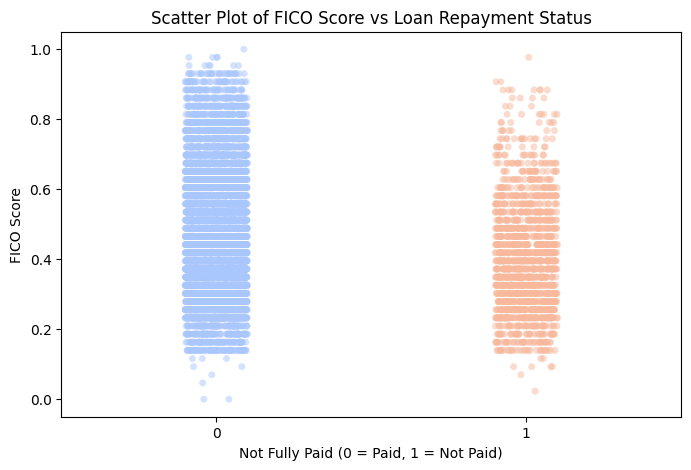

In [34]:
# Scatter plot of FICO score vs Not Fully Paid
plt.figure(figsize=(8, 5))
sns.stripplot(
    x=data["not.fully.paid"],
    y=data["fico"],
    hue=data["not.fully.paid"],  # Assign hue to x variable
    jitter=True,
    alpha=0.5,
    palette="coolwarm",
    legend=False  # Disable legend since hue is just for color
)

# Labels and title
plt.xlabel("Not Fully Paid (0 = Paid, 1 = Not Paid)")
plt.ylabel("FICO Score")
plt.title("Scatter Plot of FICO Score vs Loan Repayment Status")

plt.show()


#### 8 - days.with.cr.line

In [35]:
data["days.with.cr.line"].describe()

count     9578.000000
mean      4560.767197
std       2496.930377
min        178.958333
25%       2820.000000
50%       4139.958333
75%       5730.000000
max      17639.958330
Name: days.with.cr.line, dtype: float64

In [36]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform 'days.with.cr.line'
data["days.with.cr.line"] = scaler.fit_transform(data[["days.with.cr.line"]])

# Verify transformation
print(data["days.with.cr.line"].describe())  # Should now be between 0 and 1


count    9578.000000
mean        0.250948
std         0.143000
min         0.000000
25%         0.151254
50%         0.226848
75%         0.317911
max         1.000000
Name: days.with.cr.line, dtype: float64


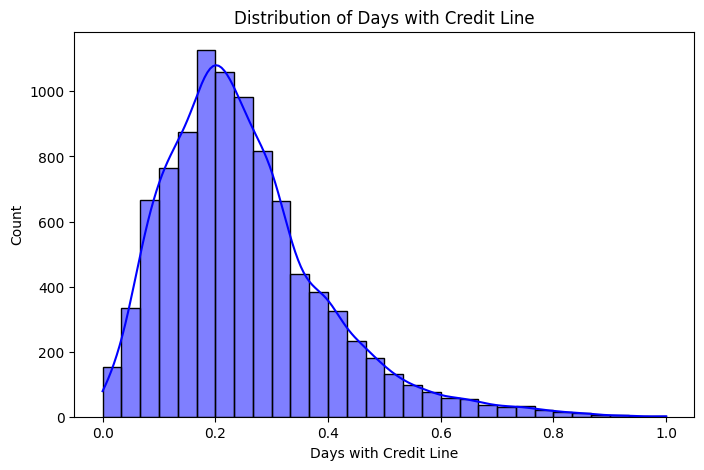

In [37]:
# Histogram of days.with.cr.line
plt.figure(figsize=(8, 5))
sns.histplot(data["days.with.cr.line"], bins=30, kde=True, color="blue")

# Labels and title
plt.xlabel("Days with Credit Line")
plt.ylabel("Count")
plt.title("Distribution of Days with Credit Line")
plt.show()

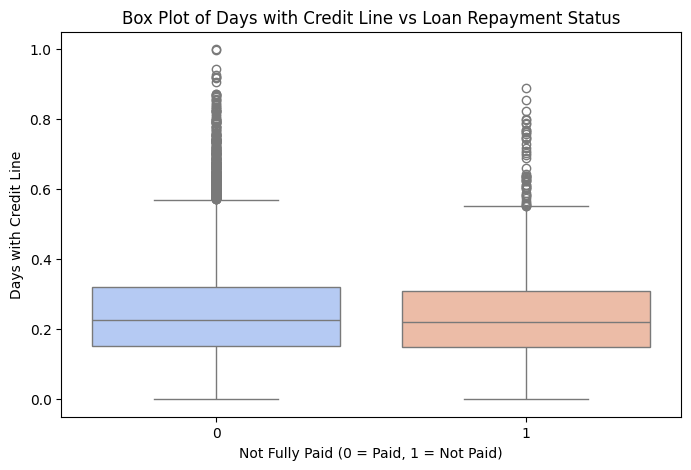

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot of Days with Credit Line vs Not Fully Paid
plt.figure(figsize=(8, 5))
sns.boxplot(
    x=data["not.fully.paid"],
    y=data["days.with.cr.line"],
    hue=data["not.fully.paid"],  # Assign hue to x variable
    palette="coolwarm",
    legend=False  # Disable legend since hue is just for color
)

# Labels and title
plt.xlabel("Not Fully Paid (0 = Paid, 1 = Not Paid)")
plt.ylabel("Days with Credit Line")
plt.title("Box Plot of Days with Credit Line vs Loan Repayment Status")

plt.show()


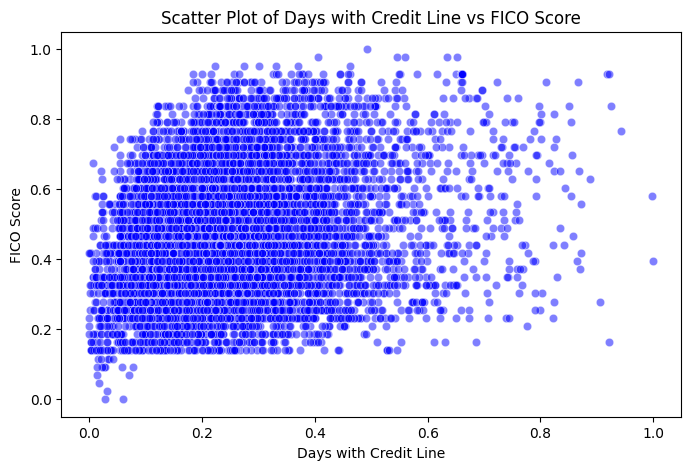

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Days with Credit Line vs FICO Score
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data["days.with.cr.line"], y=data["fico"], alpha=0.5, color="blue")

# Labels and title
plt.xlabel("Days with Credit Line")
plt.ylabel("FICO Score")
plt.title("Scatter Plot of Days with Credit Line vs FICO Score")

plt.show()

#### 9 - revol.bal

In [40]:
data['revol.bal'].describe()

count    9.578000e+03
mean     1.691396e+04
std      3.375619e+04
min      0.000000e+00
25%      3.187000e+03
50%      8.596000e+03
75%      1.824950e+04
max      1.207359e+06
Name: revol.bal, dtype: float64

In [41]:
import numpy as np
# Log transform to reduce skewness
data["revol.bal"] = np.log1p(data["revol.bal"])  # log(1 + x) avoids log(0)

# Apply MinMaxScaler after log transformation
scaler = MinMaxScaler()
data["revol.bal"] = scaler.fit_transform(data[["revol.bal"]])

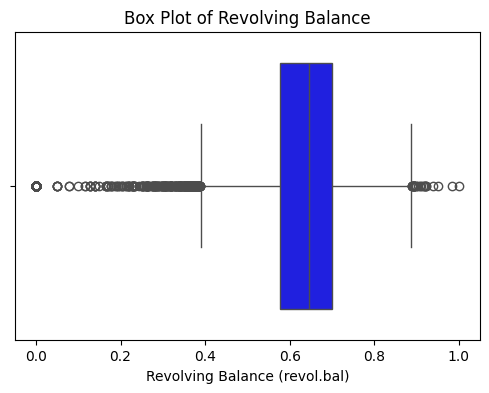

In [42]:
# Box plot for Revolving Balance (revol.bal)
plt.figure(figsize=(6, 4))
sns.boxplot(x=data["revol.bal"], color="blue")

# Labels and title
plt.xlabel("Revolving Balance (revol.bal)")
plt.title("Box Plot of Revolving Balance")

plt.show()

#### 10 - revol.util

In [43]:
data["revol.util"].describe()

count    9578.000000
mean       46.799236
std        29.014417
min         0.000000
25%        22.600000
50%        46.300000
75%        70.900000
max       119.000000
Name: revol.util, dtype: float64

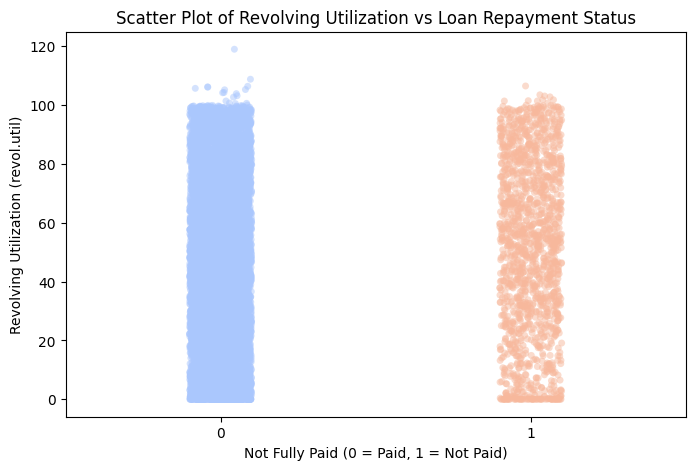

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of Revolving Utilization vs Not Fully Paid
plt.figure(figsize=(8, 5))
sns.stripplot(
    x=data["not.fully.paid"],
    y=data["revol.util"],
    hue=data["not.fully.paid"],  # Assign hue to x variable
    jitter=True,
    alpha=0.5,
    palette="coolwarm",
    legend=False  # Disable legend since hue is just for color
)

# Labels and title
plt.xlabel("Not Fully Paid (0 = Paid, 1 = Not Paid)")
plt.ylabel("Revolving Utilization (revol.util)")
plt.title("Scatter Plot of Revolving Utilization vs Loan Repayment Status")

plt.show()


In [45]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform 'revol.util'
data["revol.util"] = scaler.fit_transform(data[["revol.util"]])

# Verify transformation
data["revol.util"].describe()  # Should now be between 0 and 1

count    9578.000000
mean        0.393271
std         0.243819
min         0.000000
25%         0.189916
50%         0.389076
75%         0.595798
max         1.000000
Name: revol.util, dtype: float64

#### 11 - inq.last.6mths

In [46]:
data["inq.last.6mths"].describe()

count    9578.000000
mean        1.577469
std         2.200245
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        33.000000
Name: inq.last.6mths, dtype: float64

/var/folders/y3/g8cf6rzj7wz97zptmgzfqffc0000gn/T/ipykernel_34411/1012170223.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["inq.last.6mths"], palette="coolwarm")


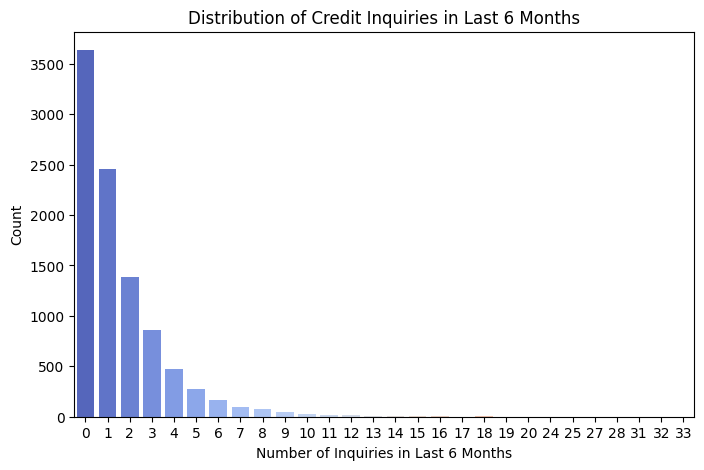

In [47]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data["inq.last.6mths"], palette="coolwarm")

plt.xlabel("Number of Inquiries in Last 6 Months")
plt.ylabel("Count")
plt.title("Distribution of Credit Inquiries in Last 6 Months")

plt.show()


In [48]:
# Log transform to reduce skewness
data["inq.last.6mths"] = np.log1p(data["inq.last.6mths"])  # log(1 + x) avoids log(0)

# Apply MinMaxScaler after log transformation
scaler = MinMaxScaler()
data["inq.last.6mths"] = scaler.fit_transform(data[["inq.last.6mths"]])
data["inq.last.6mths"].describe()

count    9578.000000
mean        0.199337
std         0.188455
min         0.000000
25%         0.000000
50%         0.196562
75%         0.311543
max         1.000000
Name: inq.last.6mths, dtype: float64

#### 12 - delinq.2yrs

In [49]:
data["delinq.2yrs"].describe()

count    9578.000000
mean        0.163708
std         0.546215
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        13.000000
Name: delinq.2yrs, dtype: float64

/var/folders/y3/g8cf6rzj7wz97zptmgzfqffc0000gn/T/ipykernel_34411/2172742337.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["delinq.2yrs"], palette="coolwarm")


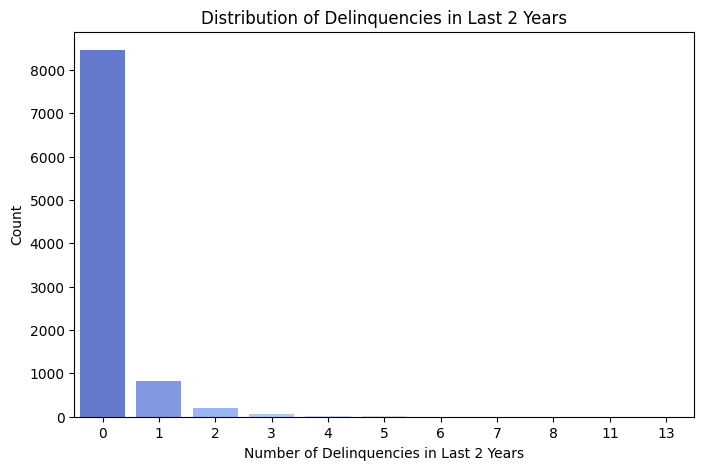

In [50]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data["delinq.2yrs"], palette="coolwarm")

plt.xlabel("Number of Delinquencies in Last 2 Years")
plt.ylabel("Count")
plt.title("Distribution of Delinquencies in Last 2 Years")

plt.show()

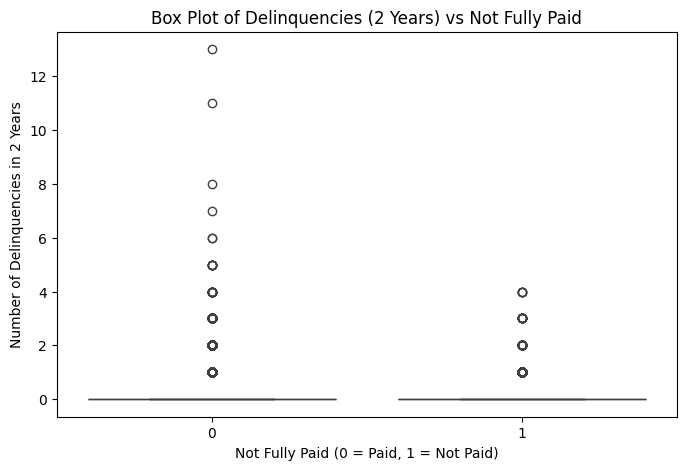

In [51]:
# Box plot of Delinquencies in 2 Years vs Not Fully Paid
plt.figure(figsize=(8, 5))
sns.boxplot(x=data["not.fully.paid"], y=data["delinq.2yrs"])

# Labels and title
plt.xlabel("Not Fully Paid (0 = Paid, 1 = Not Paid)")
plt.ylabel("Number of Delinquencies in 2 Years")
plt.title("Box Plot of Delinquencies (2 Years) vs Not Fully Paid")

plt.show()

In [52]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform 'delinq.2yrs'
data["delinq.2yrs"] = scaler.fit_transform(data[["delinq.2yrs"]])

# Verify transformation
data["delinq.2yrs"].describe()  # Should now be between 0 and 1


count    9578.000000
mean        0.012593
std         0.042017
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: delinq.2yrs, dtype: float64

#### 13 - pub.rec

In [53]:
data["pub.rec"].describe()

count    9578.000000
mean        0.062122
std         0.262126
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: pub.rec, dtype: float64

/var/folders/y3/g8cf6rzj7wz97zptmgzfqffc0000gn/T/ipykernel_34411/2413343519.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data["pub.rec"], palette="coolwarm")


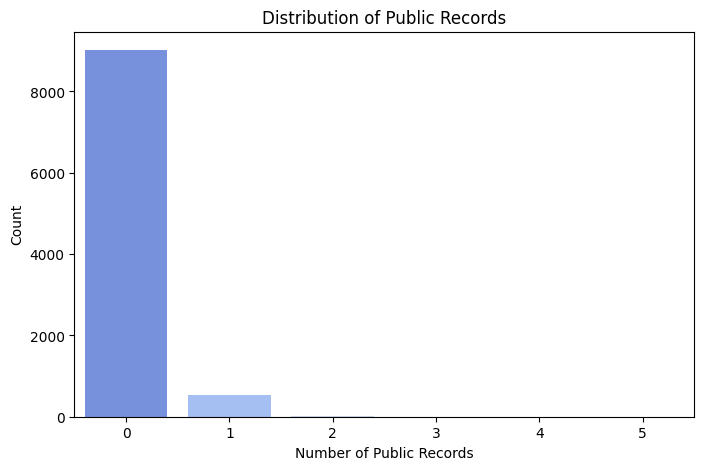

In [54]:
plt.figure(figsize=(8, 5))
sns.countplot(x=data["pub.rec"], palette="coolwarm")
plt.xlabel("Number of Public Records")
plt.ylabel("Count")
plt.title("Distribution of Public Records")

plt.show()

In [55]:
# Count of each number of public records (pub.rec)
pub_rec_counts = data["pub.rec"].value_counts().sort_index()

# Display the counts
print(pub_rec_counts)

pub.rec
0    9019
1     533
2      19
3       5
4       1
5       1
Name: count, dtype: int64


In [56]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform 'pub.rec'
data["pub.rec"] = scaler.fit_transform(data[["pub.rec"]])

# Verify transformation
print(data["pub.rec"].describe())  # Should now be between 0 and 1

count    9578.000000
mean        0.012424
std         0.052425
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: pub.rec, dtype: float64


In [57]:
data.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,0.376598,0.879888,11.350407,0.650200,0.581395,0.312754,0.733367,0.437815,0.000000,0.000000,0.0,0,0,0,1,0,0,0,0
1,1,0.301151,0.229916,11.082143,0.476969,0.441860,0.147818,0.744290,0.644538,0.000000,0.000000,0.0,0,0,1,0,0,0,0,0
2,1,0.484015,0.379883,10.373491,0.388184,0.325581,0.259495,0.582974,0.215126,0.196562,0.000000,0.0,0,0,0,1,0,0,0,0
3,1,0.260870,0.158653,11.350407,0.270360,0.465116,0.144379,0.744383,0.615126,0.196562,0.000000,0.0,0,0,0,1,0,0,0,0
4,1,0.528133,0.094378,11.299732,0.499666,0.255814,0.222613,0.604401,0.331933,0.000000,0.076923,0.0,0,0,1,0,0,0,0,0


In [58]:
#target variable Analysis - not.fully.paid

In [59]:
# Count occurrences of each class (0 and 1) in the target variable 'not.fully.paid'
target_counts = data["not.fully.paid"].value_counts()

# Calculate percentages
target_percentages = (target_counts / target_counts.sum()) * 100

# Combine counts and percentages into a DataFrame
target_summary = pd.DataFrame({
    "Count": target_counts,
    "Percentage": target_percentages
})

# Display the results
print(target_summary)

                Count  Percentage
not.fully.paid                   
0                8045   83.994571
1                1533   16.005429


In [60]:
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler

# Split data into features (X) and target variable (y)
X = data.drop(columns=["not.fully.paid"])  # Features
y = data["not.fully.paid"]  # Target variable

# Split into training and testing sets (SMOTE is applied only on training data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [61]:
from imblearn.combine import SMOTETomek

# smote_tomek = SMOTETomek(sampling_strategy=1.0, random_state=42)  # Ensure perfect balance
# X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# # Convert to Pandas Series for correct counting
# y_train_resampled = pd.Series(y_train_resampled)

# # Verify new class distribution
# print("Class distribution before SMOTE:\n", y_train.value_counts())
# print("Class distribution after SMOTE:\n", y_train_resampled.value_counts())

from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

# Verify class distribution
print("Class distribution before SMOTE:\n", y_train.value_counts())
print("Class distribution after SMOTE:\n", pd.Series(y_train_resampled).value_counts())


Class distribution before SMOTE:
 not.fully.paid
0    6436
1    1226
Name: count, dtype: int64
Class distribution after SMOTE:
 not.fully.paid
0    6392
1    6392
Name: count, dtype: int64


#### PyTorch - Deep Learning Implementation

In [62]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE

# Convert Resampled Data to PyTorch Tensors (Use SMOTE data)
X_train_tensor = torch.tensor(X_train_resampled.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Convert Test Set (Remains the Same)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader with SMOTE Data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train_resampled.to_numpy())
class_weights = torch.tensor([class_weights[0], class_weights[1] * 0.7], dtype=torch.float32)  # Reduce class 1 weight

# Define Focal Loss (Alternative to BCE)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

import torch.nn.functional as F

class LoanNN(nn.Module):
    def __init__(self, input_size):
        super(LoanNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # Increased neurons
        self.ln1 = nn.LayerNorm(128)  # More stable than BatchNorm
        self.swish = lambda x: x * torch.sigmoid(x)  # Swish Activation
        self.dropout1 = nn.Dropout(0.15)  # Small dropout for generalization

        self.fc2 = nn.Linear(128, 64)
        self.ln2 = nn.LayerNorm(64)
        self.dropout2 = nn.Dropout(0.15)

        self.fc3 = nn.Linear(64, 32)
        self.ln3 = nn.LayerNorm(32)
        self.dropout3 = nn.Dropout(0.1)

        self.fc4 = nn.Linear(32, 1)  # Output Layer

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.swish(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.ln2(x)
        x = self.swish(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.ln3(x)
        x = self.swish(x)
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

# Initialize Model
input_size = X_train.shape[1]
model = LoanNN(input_size)

##########################################
# Use Focal Loss instead of BCE
criterion = FocalLoss(alpha=0.25, gamma=2)
##########################################
##########################################
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.5], dtype=torch.float32))  # Tune weight
##########################################


# Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=0.0006, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early Stopping Parameters
patience = 5
best_loss = float("inf")
counter = 0

# Training Loop with Early Stopping and Scheduler update
epochs = 200
for epoch in range(epochs):
    epoch_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch.squeeze())  # Ensure correct shape
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    # Update the learning rate scheduler based on training loss
    scheduler.step(epoch_loss)

    # Early Stopping Logic based on training loss (ideally, use validation loss)
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        counter = 0  # Reset counter if loss improves
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best loss: {best_loss:.4f}")
            break

# Evaluate Model on Test Data
model.eval()
with torch.no_grad():
    y_test_pred_prob = torch.sigmoid(model(X_test_tensor))  # Apply sigmoid to convert logits to probabilities

    
##################################################################
# # Find the Best Threshold for Precision-Recall Balance
# best_threshold = None
# best_f1 = 0

# print("\n🔍 **Threshold Tuning Results:**")
# for threshold in np.arange(0.1, 0.9, 0.05):  # Expanded search space for better threshold tuning
#     y_test_pred = (y_test_pred_prob > threshold).float()
    
#     precision = precision_score(y_test_tensor.numpy(), y_test_pred.numpy(), zero_division=0)
#     recall = recall_score(y_test_tensor.numpy(), y_test_pred.numpy())
#     f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
#     print(f"Threshold: {threshold:.2f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-score: {f1:.4f}")

#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = threshold

# print(f"\n Best Threshold Found: {best_threshold:.2f} with F1-score: {best_f1:.4f}")
##################################################################

##################################################################
# best threshhold based on the comment above
best_threshold = 0.45
##################################################################

# Apply the best threshold
y_test_pred = (y_test_pred_prob > best_threshold).float()
##################################################################


# Compute Final Recall & Classification Report
test_recall = recall_score(y_test_tensor.numpy(), y_test_pred.numpy())
print(f"\nFinal Test Recall: {test_recall:.4f}")

print("\n📊 **Final Classification Report:**")
print(classification_report(y_test_tensor.numpy(), y_test_pred.numpy(), digits=4))

# # Debugging: Analyze misclassified loans (False Positives & False Negatives)
# df_results = pd.DataFrame({
#     "Actual": y_test_tensor.numpy().flatten(), 
#     "Predicted_Prob": y_test_pred_prob.numpy().flatten(), 
#     "Predicted": y_test_pred.numpy().flatten()
# })

Epoch 1/200, Loss: 0.0426
Epoch 2/200, Loss: 0.0413
Epoch 3/200, Loss: 0.0407
Epoch 4/200, Loss: 0.0405
Epoch 5/200, Loss: 0.0404
Epoch 6/200, Loss: 0.0402
Epoch 7/200, Loss: 0.0400
Epoch 8/200, Loss: 0.0400
Epoch 9/200, Loss: 0.0398
Epoch 10/200, Loss: 0.0397
Epoch 11/200, Loss: 0.0397
Epoch 12/200, Loss: 0.0397
Epoch 13/200, Loss: 0.0396
Epoch 14/200, Loss: 0.0396
Epoch 15/200, Loss: 0.0395
Epoch 16/200, Loss: 0.0395
Epoch 17/200, Loss: 0.0394
Epoch 18/200, Loss: 0.0393
Epoch 19/200, Loss: 0.0393
Epoch 20/200, Loss: 0.0393
Epoch 21/200, Loss: 0.0392
Epoch 22/200, Loss: 0.0393
Epoch 23/200, Loss: 0.0392
Epoch 24/200, Loss: 0.0392
Epoch 25/200, Loss: 0.0390
Epoch 26/200, Loss: 0.0390
Epoch 27/200, Loss: 0.0389
Epoch 28/200, Loss: 0.0390
Epoch 29/200, Loss: 0.0388
Epoch 30/200, Loss: 0.0389
Epoch 31/200, Loss: 0.0386
Epoch 32/200, Loss: 0.0388
Epoch 33/200, Loss: 0.0387
Epoch 34/200, Loss: 0.0386
Epoch 35/200, Loss: 0.0385
Epoch 36/200, Loss: 0.0384
Epoch 37/200, Loss: 0.0384
Epoch 38/2

#### Evaluation Metrics 

✔ False Negatives (FN) are worse because misclassifying a high-risk borrower as low-risk could result in financial losses.
✔ This means Recall (Sensitivity) is more important than Precision.

In [63]:
print(classification_report(y_test_tensor.numpy(), y_test_pred.numpy()))

              precision    recall  f1-score   support

         0.0       0.88      0.45      0.60      1609
         1.0       0.19      0.68      0.30       307

    accuracy                           0.49      1916
   macro avg       0.54      0.56      0.45      1916
weighted avg       0.77      0.49      0.55      1916



In [64]:
auc_score = roc_auc_score(y_test_tensor.numpy(), y_test_pred.numpy())
print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.5644


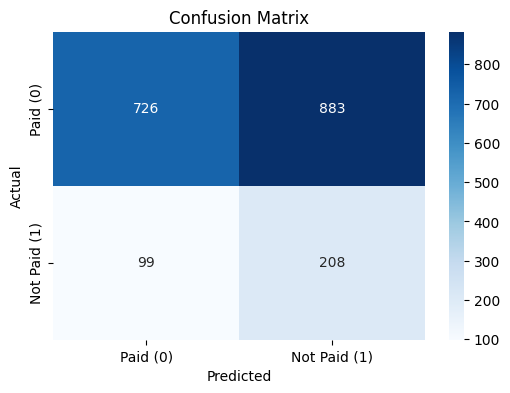

In [65]:
cm = confusion_matrix(y_test_tensor.numpy(), y_test_pred.numpy())

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Paid (0)", "Not Paid (1)"], yticklabels=["Paid (0)", "Not Paid (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Classical Machine Learning Results

/opt/anaconda3/envs/simplienv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Logistic Regression Performance:

              precision    recall  f1-score   support

           0       0.89      0.65      0.75      1609
           1       0.24      0.58      0.34       307

    accuracy                           0.64      1916
   macro avg       0.57      0.62      0.54      1916
weighted avg       0.79      0.64      0.68      1916

🔹 Decision Tree Performance:

              precision    recall  f1-score   support

           0       0.87      0.71      0.78      1609
           1       0.23      0.46      0.31       307

    accuracy                           0.67      1916
   macro avg       0.55      0.58      0.54      1916
weighted avg       0.77      0.67      0.71      1916

🔹 Random Forest Performance:

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1609
           1       0.31      0.15      0.20       307

    accuracy                           0.81      1916
   macro avg       0.58      0.5

/opt/anaconda3/envs/simplienv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:31:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Performance:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1609
           1       0.24      0.21      0.22       307

    accuracy                           0.77      1916
   macro avg       0.54      0.54      0.54      1916
weighted avg       0.75      0.77      0.76      1916

🔹 SVM Performance:

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1609
           1       0.27      0.42      0.33       307

    accuracy                           0.73      1916
   macro avg       0.57      0.60      0.58      1916
weighted avg       0.78      0.73      0.75      1916



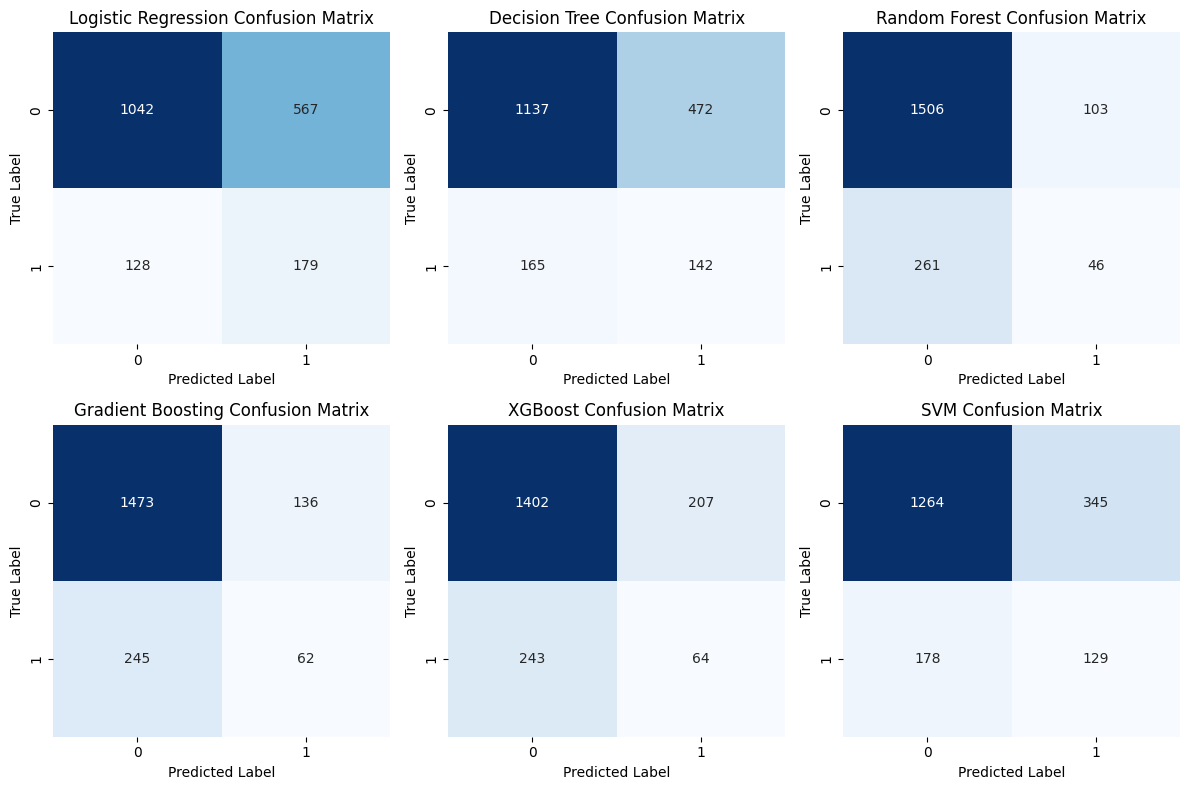

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(class_weight="balanced", random_state=42),
    "Decision Tree": DecisionTreeClassifier(class_weight="balanced", max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=len(y_train_resampled) / sum(y_train_resampled), 
                              use_label_encoder=False, eval_metric='logloss'),
    "SVM": SVC(class_weight="balanced", probability=True, random_state=42)
}

# Train and evaluate models
plt.figure(figsize=(12, 8))
for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train_resampled, y_train_resampled)  # Train model
    y_pred = model.predict(X_test)  # Predictions

    # Print Classification Report
    print(f"🔹 {name} Performance:\n")
    print(classification_report(y_test, y_pred))
    print("="*50)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.subplot(2, 3, i)  # Arrange in a grid (2 rows, 3 columns)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

plt.tight_layout()
plt.show()


In [67]:
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC-AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"🔹 {name} ROC-AUC Score: {auc:.4f}")


🔹 Logistic Regression ROC-AUC Score: 0.6821
🔹 Decision Tree ROC-AUC Score: 0.6220
🔹 Random Forest ROC-AUC Score: 0.6550
🔹 Gradient Boosting ROC-AUC Score: 0.6318
🔹 XGBoost ROC-AUC Score: 0.6142
🔹 SVM ROC-AUC Score: 0.6772


# 🔍 Which Metrics Matter Most?

## ✅ 1. Recall (`not.fully.paid = 1`) → **High Priority**
- **Goal:** **≥ 90%**  
- **Why?**  
  - We **want to catch as many risky loans as possible**.  
  - **Minimizes False Negatives (FN)** → Reduces the risk of approving bad loans.  
  - **If recall is too low**, the model **misses too many default cases**, making it unreliable.  

---

## ⚠️ 2. Precision (`not.fully.paid = 1`) → **Needs to be Reasonable**
- **Goal:** **≥ 30% (Preferably higher)**  
- **Why?**  
  - **Too low precision = Too many false alarms** (predicting defaults that won’t happen).  
  - We need to **avoid rejecting too many good borrowers**.  
  - If precision is **too low (<20%)**, lenders may lose money by rejecting safe loans unnecessarily.  

---

## ⚖️ 3. F1-Score → **The Balance Metric**
- **Goal:** **≥ 40%**  
- **Why?**  
  - It **balances recall and precision**.  
  - If **recall is too high but precision is too low**, F1-score drops.  
  - A strong F1-score means the model is making meaningful predictions.  

---

## ❌ 4. Accuracy → **Not a Priority**
- **Why Not?**  
  - The dataset is **imbalanced** → **Most loans are fully paid (`0`), so a naive model predicting all `0` would have high accuracy but be useless**.  
  - Instead, we care about **recall & precision for `not.fully.paid = 1`**.  
